# Group Project - Social Media Analysis
## EDA part2
Author: Yuwei Zhu

In [1]:
# import module
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import os
import re
import spacy
import preprocessor as p

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter
from operator import itemgetter

In [2]:
# load data
df = pd.DataFrame()
path = 'data/'
file_lst = os.listdir(path)
for i in file_lst:
    data = pd.read_excel(os.path.join('data/'+ i),index_col = None)
    df = df.append(data)

# Data preprocessing

In [3]:
#helper functions

## Seeder
# :seed to make all processes deterministic 
def seed_everything(seed=0):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

In [4]:
## Memory Reducer                                     
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [5]:
# drop columns with too many NaNs
def drop_nan_column(threshold, df):
    new_df = df.copy()
    total = len(df)
    for column in df:
        percent = df[column].isnull().sum()/total
        if percent > threshold:
            new_df = new_df.drop(columns = [column])
    return new_df

In [6]:
# drop duplicate rows
df = df.drop_duplicates()

In [7]:
len(df)

511269

In [8]:
# drop rows with empty text
data.drop(data[data['Sound Bite Text'].isnull()].index, inplace = True)

In [9]:
len(df)

511269

In [11]:
# check df columns types
for col in df.columns:
    print('{0:15s} data type is: {1:10s}'.format(str(col), str(df[col].dtype)))

Post ID         data type is: object    
Sound Bite Text data type is: object    
Ratings and Scores data type is: float64   
Title           data type is: object    
Source Type     data type is: object    
Post Type       data type is: object    
Media Type      data type is: object    
URL             data type is: object    
Domain          data type is: object    
Published Date (GMT-04:00) New York data type is: object    
Author Gender   data type is: object    
Author URL      data type is: object    
Author Name     data type is: object    
Author Handle   data type is: object    
Author ID       data type is: object    
Author Location - Country 1 data type is: object    
Author Location - State/Province 1 data type is: object    
Author Location - City 1 data type is: object    
Author Location - Country 2 data type is: object    
Author Location - State/Province 2 data type is: object    
Author Location - City 2 data type is: object    
Author Location - Other data type is

In [10]:
# convert date column to type datetime
df['Published Date (GMT-04:00) New York'] = pd.to_datetime(df['Published Date (GMT-04:00) New York'])

In [11]:
# reduce memory
df = reduce_mem_usage(df)

Mem. usage decreased to 146.28 Mb (10.7% reduction)


In [15]:
df.head(3).transpose()

,0,1,2
Post ID,http://www.cnet.com/news/harrison-ford-drinks-...,18244424300214682891,4d3a787535.441983
Sound Bite Text,"So out came the Bruichladdich , a fine scotch ...",Iphone X Gsmarena Specs and Price: The Iphone ...,com All products are 100% Original. No Refurbi...
Ratings and Scores,NaN,NaN,NaN
Title,"Harrison Ford drinks scotch, tells jokes with ...",Iphone X Gsmarena Specs and Price,"Buy Apple iPhone X 256GB New Space Gray $1,249"
Source Type,Blogs,Blogs,Forums
Post Type,Original,Original,Original
Media Type,No Media,No Media,No Media
URL,http://www.cnet.com/news/harrison-ford-drinks-...,http://www.techlass.com/2017/09/iphone-x-gsmar...,http://www.marineengine.com/boat-forum/showthr...
Domain,cnet.com,techlass.com,marineengine.com
Published Date (GMT-04:00) New York,2017-09-29 05:06:00,2017-09-28 03:35:00,2017-09-28 13:53:00


In [16]:
df.describe()

,Ratings and Scores,No. of Followers/Daily Unique Visitors,Richness,Tags,Total Engagements,Post Comments,Post Likes,Post Shares,Post Views,Post Dislikes,Product Hierarchy,Rating
count,0.0,4.925180e+05,492518.0,0.0,52474.000000,30619.0,50253.000000,1168.00,0.0,0.0,0.0,2190.000000
mean,NaN,5.672792e+04,NaN,NaN,364.024841,inf,368.172729,inf,NaN,NaN,NaN,3.619141
std,NaN,1.514392e+06,0.0,NaN,2545.526611,inf,2524.669922,inf,NaN,NaN,NaN,1.428711
min,NaN,0.000000e+00,0.0,NaN,1.000000,1.0,1.000000,1.00,NaN,NaN,NaN,0.000000
25%,NaN,0.000000e+00,0.0,NaN,9.000000,1.0,10.000000,4.00,NaN,NaN,NaN,3.000000
50%,NaN,0.000000e+00,1.0,NaN,28.000000,3.0,29.000000,12.00,NaN,NaN,NaN,4.000000
75%,NaN,0.000000e+00,2.0,NaN,79.000000,6.0,79.000000,47.25,NaN,NaN,NaN,5.000000
max,NaN,1.500000e+08,12.0,NaN,172094.000000,11224.0,158629.000000,12728.00,NaN,NaN,NaN,5.000000


# EDA

## Post Profile 
### Number of post in each day

In [12]:
# date
df['date_day'] = df['Published Date (GMT-04:00) New York'].dt.date

/Users/zhuyuwei/Library/Python/3.7/lib/python/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


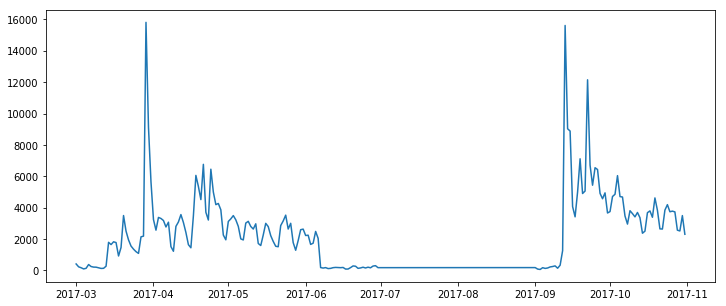

In [13]:
plt.rcParams["figure.figsize"] = (12,5)
plt.plot(df.groupby(['date_day'])['Post ID'].count())

The peak number of post for both product were close. However, iPhone 8 and X had an additional posting peak within 10 days. Also, the following discussion about iPhone on social media looks more intenvise than Samsung Galaxy S8.

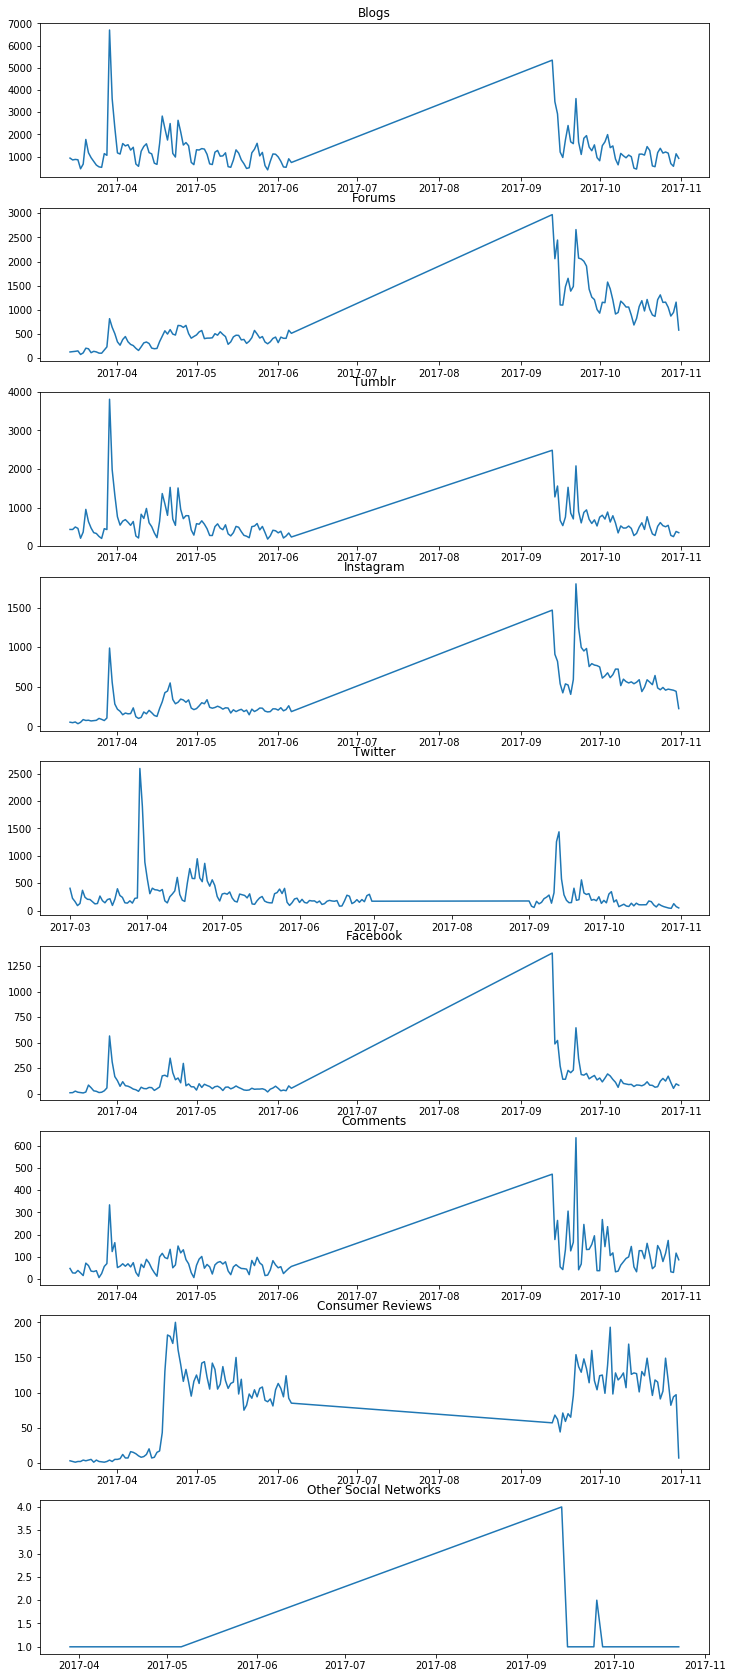

In [111]:
# seperate by source
plt.rcParams["figure.figsize"] = (12,30)
sources = df['Source Type'].value_counts()
for i in range(1,10):
    plt.subplot(9,1,i)
    source_data = df.loc[df['Source Type'] == str(sources.index[i-1])]
    plt.title(str(sources.index[i-1]))
    plt.plot(source_data.groupby(['date_day'])['Post ID'].count())

User posts and comments on different sources are not totally simultaneously. When Samsung Galaxy S8 released, twitter and consumer reviews response later than other social media. However, when iPhone 8 and iPhone X released, all the other sources excepts consumer reviews response in relatively same time.

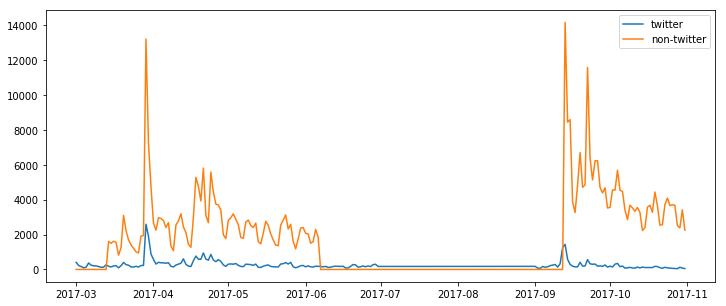

In [109]:
# twitter vs. non-twitter
plt.rcParams["figure.figsize"] = (12,5)
twitter = df.loc[df['Source Type'] == 'Twitter']
non_twitter = df.loc[df['Source Type'] != 'Twitter']
labels = ['twitter', 'non-twitter']

plt.plot(twitter.groupby(['date_day'])['Post ID'].count())
plt.plot(non_twitter.groupby(['date_day'])['Post ID'].count())
plt.legend(labels)

When samsung Galaxy S8 released, twitter and non-twitter responses similar. However, users on twitter response were not so overwhelming comparing to other sources.

## Top users

In [147]:
followers = df.groupby('Post ID').agg({'No. of Followers/Daily Unique Visitors': 'max'})
followers = followers.loc[followers['No. of Followers/Daily Unique Visitors'] > 10]
count = followers['No. of Followers/Daily Unique Visitors'].value_counts().tolist()
follower_number = followers['No. of Followers/Daily Unique Visitors'].value_counts().index.tolist()

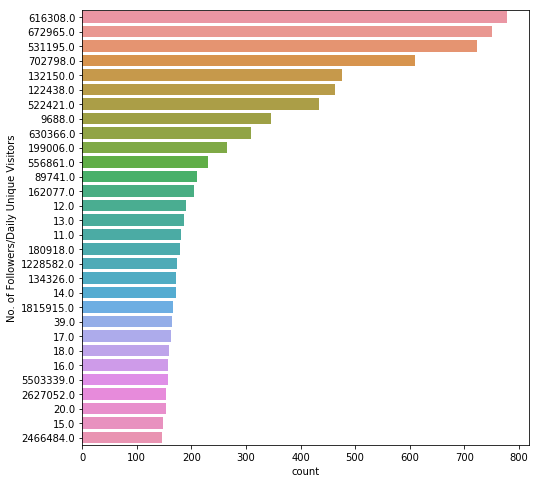

In [148]:
plt.figure(figsize = (8,8))
sns.countplot(y = followers["No. of Followers/Daily Unique Visitors"], \
              order = followers["No. of Followers/Daily Unique Visitors"].value_counts().index[:30])
plt.show()

In [150]:
# top 10 user
followers.reset_index().sort_values(by = 'No. of Followers/Daily Unique Visitors', ascending = False).head(10)

,Post ID,No. of Followers/Daily Unique Visitors
9193,176358752382299_1821787884506036_1833824436635714,150000000.0
192,104753296264554_1478921125514424,127774880.0
191,104753296264554_1477511468988723,127774880.0
330,107593572595009_1514091941945158_1515345551819797,116854496.0
297,107593572595009_1453195688034784_1466950189992667,116854496.0
1231,133803174373_10155328716544374_10155335443599374,116854496.0
335,107593572595009_1660400803980937,116854496.0
1230,133803174373_10155328236859374_10155335472539374,116854496.0
1301,137362696323133_1442515439141179_1443192399073483,116854496.0
1229,133803174373_10155328220104374_10155335442624374,116854496.0


## Correlation

In [157]:
# drop nan columns
drop_nan = drop_nan_column(0.95, df)

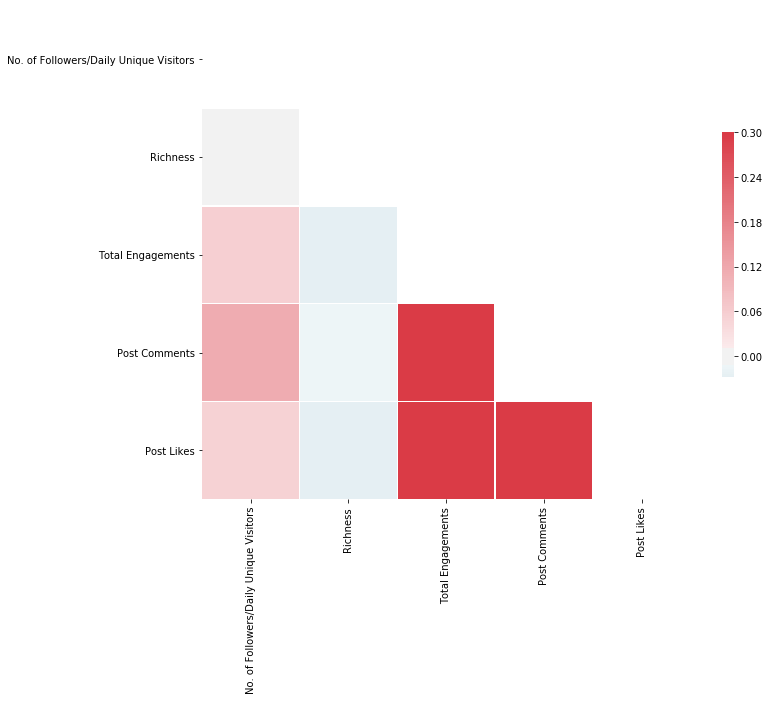

In [158]:
correlation_matrix = drop_nan.corr()
mask = np.zeros_like(correlation_matrix, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(correlation_matrix, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

## Feature Extraction

In [14]:
# drop replies and comments, only keep the original post
nlp_data = df.loc[df['Post Type'] == 'Original'].reset_index()[['Sound Bite Text']]

In [15]:
nlp = spacy.load('en_core_web_sm', disable = ['ner', 'parser'], max_length = 1000000000)

In [16]:
nlp_data = nlp_data.fillna('')

In [17]:
def clean_data(df):
    text = df
    #Remove punctuations
    text = re.sub('[^a-zA-Z]', ' ', text)
    
    #Convert to lowercase
    text = text.lower()
    
    #remove tags
    text=re.sub("&lt;/?.*?&gt;"," &lt;&gt; ",text)
    
    # remove special characters and digits
    text=re.sub("(\\d|\\W)+"," ",text)
   
    return text

In [18]:
nlp_data['Sound Bite Text'] = nlp_data['Sound Bite Text'].apply(clean_data)

In [19]:
nlp_data['Sound Bite Text'] = nlp_data['Sound Bite Text'].apply(lambda x: p.clean(x))

In [21]:
# tokenize
nlp_data['clean_text'] = nlp_data['Sound Bite Text'].apply(lambda x: nlp.tokenizer(x))

In [23]:
# split product
def conditions(df):
    if ('iphone' in df['Sound Bite Text']):
        product = 'iPhone'
        return product
    if ('galaxy' in df['Sound Bite Text']):
        product = 'Galaxy'
        return product
    else:
        product = 'not known'
        return product

In [24]:
nlp_data['product'] = nlp_data.apply(conditions, axis = 1)

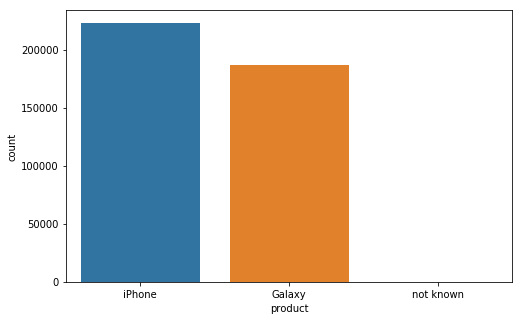

In [25]:
plt.figure(figsize = (8,5))
sns.countplot(nlp_data['product'], order = nlp_data['product'].value_counts().index)
plt.show()

In [26]:
# lemma
def lemma(df):
    lemma_text = []
    for i in df['clean_text']:
        lemma_text.append(i.lemma_)
    return lemma_text

In [27]:
nlp_data['lemma'] = nlp_data.apply(lemma, axis = 1)

In [28]:
# remove stopwords
def stopwords(df):
    filtered_sentence = []
    for word in df['lemma']:
        lexeme = nlp.vocab[word]
        if lexeme.is_stop == False:
            filtered_sentence.append(word) 
    return filtered_sentence

In [29]:
nlp_data['clean'] = nlp_data.apply(stopwords, axis = 1)

## Word Cloud

In [31]:
# create bag of words
iphone = nlp_data.loc[nlp_data['product'] == 'iPhone']['clean'].tolist()
galaxy = nlp_data.loc[nlp_data['product'] == 'Galaxy']['clean'].tolist()

In [32]:
iphone = [word for sublist in iphone for word in sublist]

In [33]:
galaxy = [word for sublist in galaxy for word in sublist]

In [34]:
iphone = " ".join(iphone)
galaxy = " ".join(galaxy)

In [35]:
spacy_stopwords = spacy.lang.en.stop_words.STOP_WORDS

In [36]:
iphone_stopwords = spacy_stopwords
iphone_stopwords.add('iphone')
iphone_stopwords.add('samsung')
iphone_stopwords.add('PRON')
iphone_stopwords.add('apple')
iphone_stopwords.add('plus')
iphone_stopwords.add('phone')
iphone_stopwords.add('8')
iphone_stopwords.add('x')
iphone_stopwords.add('s')
iphone_stopwords.add('t')
iphone_stopwords.add('ift')
iphone_stopwords.add('tt')
iphone_stopwords.add('http')

In [37]:
galaxy_stopwords = spacy_stopwords
galaxy_stopwords.add('galaxy')
galaxy_stopwords.add('samsung')
galaxy_stopwords.add('smartphone')
galaxy_stopwords.add('s7')
galaxy_stopwords.add('s8')
galaxy_stopwords.add('lg')
galaxy_stopwords.add('g6')
galaxy_stopwords.add('ift')
galaxy_stopwords.add('tt')
galaxy_stopwords.add('http')
galaxy_stopwords.add('https')

In [38]:
nlp_data.head()

,Sound Bite Text,clean_text,product,lemma,clean
0,so out came the bruichladdich a fine scotch of...,"(so, out, came, the, bruichladdich, a, fine, s...",iPhone,"[so, out, come, the, bruichladdich, a, fine, s...","[come, bruichladdich, fine, scotch, hebrides, ..."
1,iphone x gsmarena specs and price the iphone x...,"(iphone, x, gsmarena, specs, and, price, the, ...",iPhone,"[iphone, x, gsmarena, spec, and, price, the, i...","[iphone, x, gsmarena, spec, price, iphone, x, ..."
2,com all products are original no refurbish com...,"(com, all, products, are, original, no, refurb...",iPhone,"[com, all, product, be, original, no, refurbis...","[com, product, original, refurbish, come, soon..."
3,from my standpoint is sounds like a better pho...,"(from, my, standpoint, is, sounds, like, a, be...",iPhone,"[from, my, standpoint, be, sound, like, a, wel...","[standpoint, sound, like, phone, note, cheap, ..."
4,jet black according to me is not bad but quite...,"(jet, black, according, to, me, is, not, bad, ...",iPhone,"[jet, black, accord, to, me, be, not, bad, but...","[jet, black, accord, bad, dull, look, space, g..."


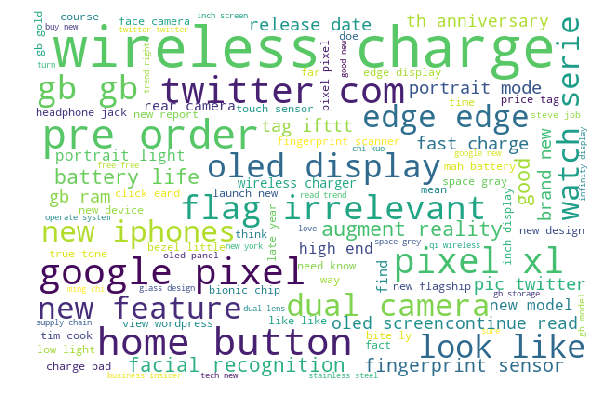

In [39]:
#Word cloud
plt.figure(figsize = (10,10))
wordcloud = WordCloud(
                          background_color='white',
                          stopwords=iphone_stopwords,
                          max_words=100,
                          max_font_size=60, 
                          width=600, 
                          height=400,
                          random_state=42
                         ).generate(iphone)
print(wordcloud)
fig = plt.figure(1)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()
fig.savefig("iphone_word1.png", dpi=900)

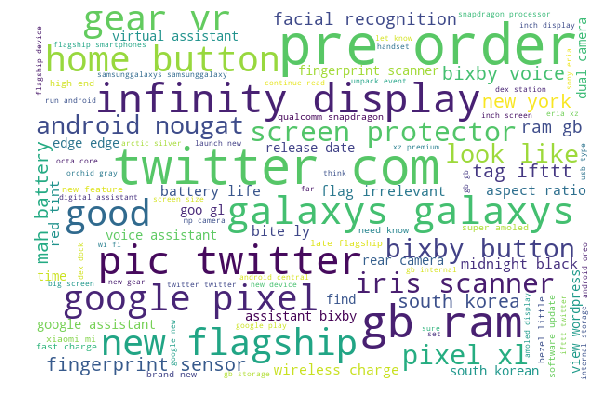

In [40]:
plt.figure(figsize = (10,10))
wordcloud = WordCloud(
                          background_color='white',
                          stopwords=galaxy_stopwords,
                          max_words=100,
                          max_font_size=60,
                          width=600, 
                          height=400,
                          random_state=42
                         ).generate(galaxy)
print(wordcloud)
fig = plt.figure(1)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()
fig.savefig("galaxy_word1.png", dpi=900)

## Top n words

In [41]:
iphone = nlp_data.loc[nlp_data['product'] == 'iPhone']
galaxy = nlp_data.loc[nlp_data['product'] == 'Galaxy']

In [42]:
from collections import Counter
histogram = Counter()
for row in iphone['clean']:
    for word in row:
        if word not in iphone_stopwords:
            histogram[word] += 1

In [43]:
iphone_sorted_lemma_count_pairs = sorted(histogram.items(),
                                  reverse=True,
                                  key=itemgetter(1))

Text(0, 0.5, 'Raw count')

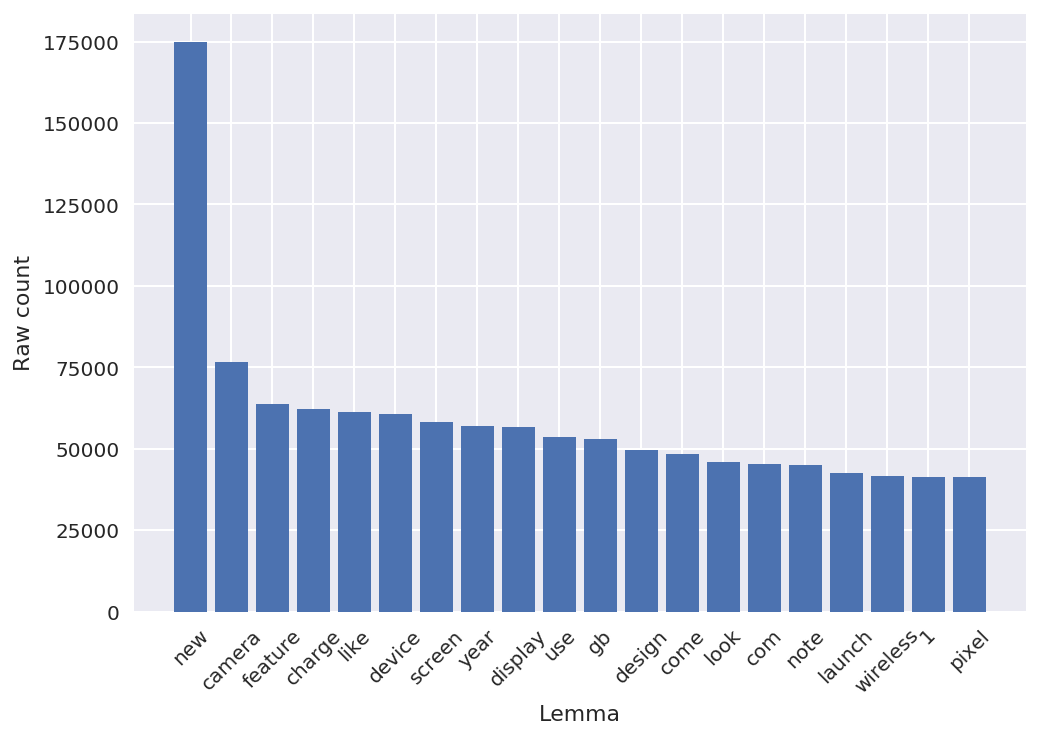

In [44]:
plt.style.use('seaborn')  
%config InlineBackend.figure_format = 'retina' 

num_top_lemmas_to_plot = 20
top_lemmas = [lemma for lemma, count in iphone_sorted_lemma_count_pairs[:num_top_lemmas_to_plot]]
top_counts = [count for lemma, count in iphone_sorted_lemma_count_pairs[:num_top_lemmas_to_plot]]
plt.bar(range(num_top_lemmas_to_plot), top_counts)
plt.xticks(range(num_top_lemmas_to_plot), top_lemmas, rotation=45)
plt.xlabel('Lemma')
plt.ylabel('Raw count')

In [45]:
histogram = Counter()
for row in galaxy['clean']:
    for word in row:
        if word not in iphone_stopwords:
            histogram[word] += 1

In [46]:
galaxy_sorted_lemma_count_pairs = sorted(histogram.items(),
                                  reverse=True,
                                  key=itemgetter(1))

Text(0, 0.5, 'Raw count')

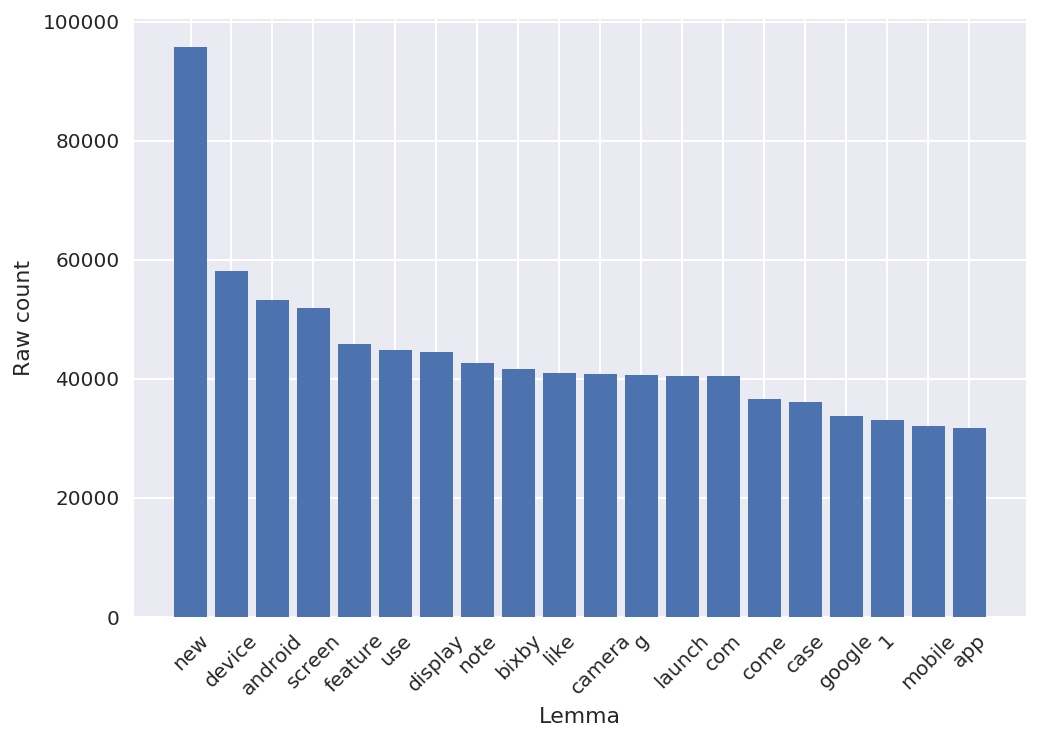

In [47]:
plt.style.use('seaborn')  
%config InlineBackend.figure_format = 'retina' 

num_top_lemmas_to_plot = 20
top_lemmas = [lemma for lemma, count in galaxy_sorted_lemma_count_pairs[:num_top_lemmas_to_plot]]
top_counts = [count for lemma, count in galaxy_sorted_lemma_count_pairs[:num_top_lemmas_to_plot]]
plt.bar(range(num_top_lemmas_to_plot), top_counts)
plt.xticks(range(num_top_lemmas_to_plot), top_lemmas, rotation=45)
plt.xlabel('Lemma')
plt.ylabel('Raw count')

## Adj

In [76]:
iphone = nlp_data.loc[nlp_data['product'] == 'iPhone']

In [134]:
# adj
iphone_histogram = Counter()
for row in iphone['clean_text']:
    for word in row:
        lexeme = nlp.vocab[word.lemma_]
        if lexeme.is_stop == False:
            if word.pos_ == 'ADJ':
                iphone_histogram[str(word)] +=1

In [137]:
# drop some words
iphone_histogram['iphone'] = 0
iphone_histogram['new'] = 0
iphone_histogram['samsung'] = 0
iphone_histogram['more'] = 0
iphone_histogram['other'] = 0
iphone_histogram['last'] = 0
iphone_histogram['next'] = 0
iphone_histogram['few'] = 0
iphone_histogram['many'] = 0
iphone_histogram['lastest'] = 0
iphone_histogram['much'] = 0

In [138]:
iphone_sorted_lemma_count_pairs = sorted(iphone_histogram.items(),
                                  reverse=True,
                                  key=itemgetter(1))

Text(0, 0.5, 'Raw count')

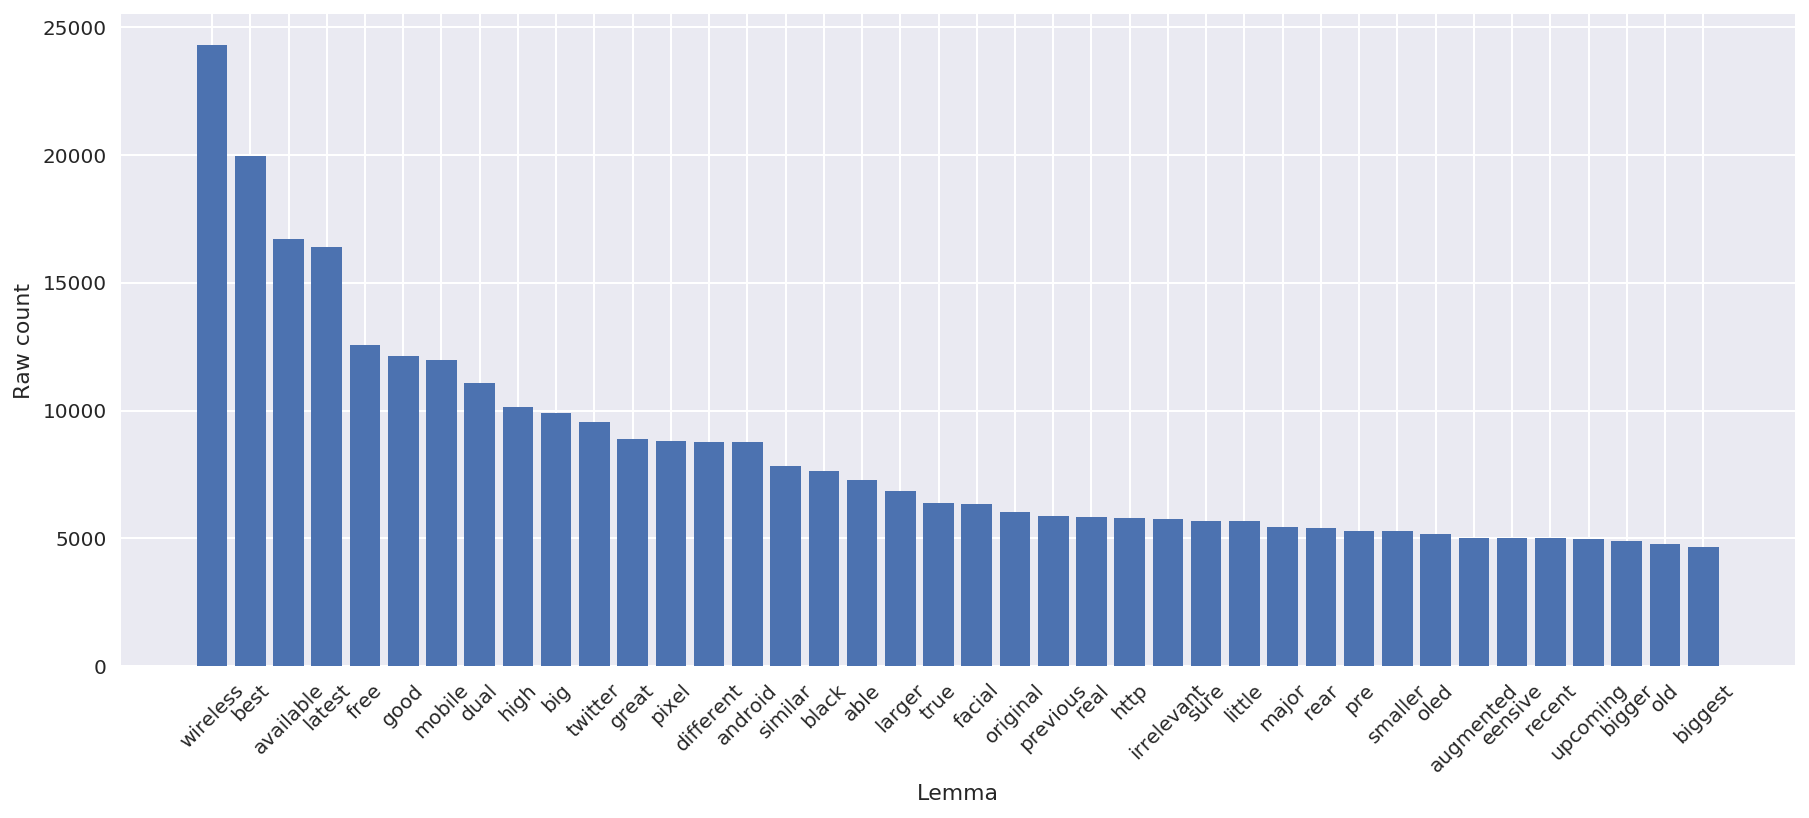

In [139]:
plt.figure(figsize = (15,6))
plt.style.use('seaborn')  
%config InlineBackend.figure_format = 'retina' 

num_top_lemmas_to_plot = 40
top_lemmas = [lemma for lemma, count in iphone_sorted_lemma_count_pairs[:num_top_lemmas_to_plot]]
top_counts = [count for lemma, count in iphone_sorted_lemma_count_pairs[:num_top_lemmas_to_plot]]
plt.bar(range(num_top_lemmas_to_plot), top_counts)
plt.xticks(range(num_top_lemmas_to_plot), top_lemmas, rotation=45)
plt.xlabel('Lemma')
plt.ylabel('Raw count')

In [103]:
galaxy = nlp_data.loc[nlp_data['product'] == 'Galaxy']

In [140]:
# adj
galaxy_histogram = Counter()
for row in galaxy['clean_text']:
    for word in row:
        lexeme = nlp.vocab[word.lemma_]
        if lexeme.is_stop == False:
            if word.pos_ == 'ADJ':
                galaxy_histogram[str(word)] +=1

In [144]:
galaxy_histogram['new'] = 0
galaxy_histogram['samsung'] = 0
galaxy_histogram['more'] = 0
galaxy_histogram['other'] = 0
galaxy_histogram['lastest'] = 0
galaxy_histogram['few'] = 0
galaxy_histogram['next'] = 0
galaxy_histogram['last'] = 0
galaxy_histogram['lg'] = 0

In [145]:
galaxy_sorted_lemma_count_pairs = sorted(galaxy_histogram.items(),
                                  reverse=True,
                                  key=itemgetter(1))

Text(0, 0.5, 'Raw count')

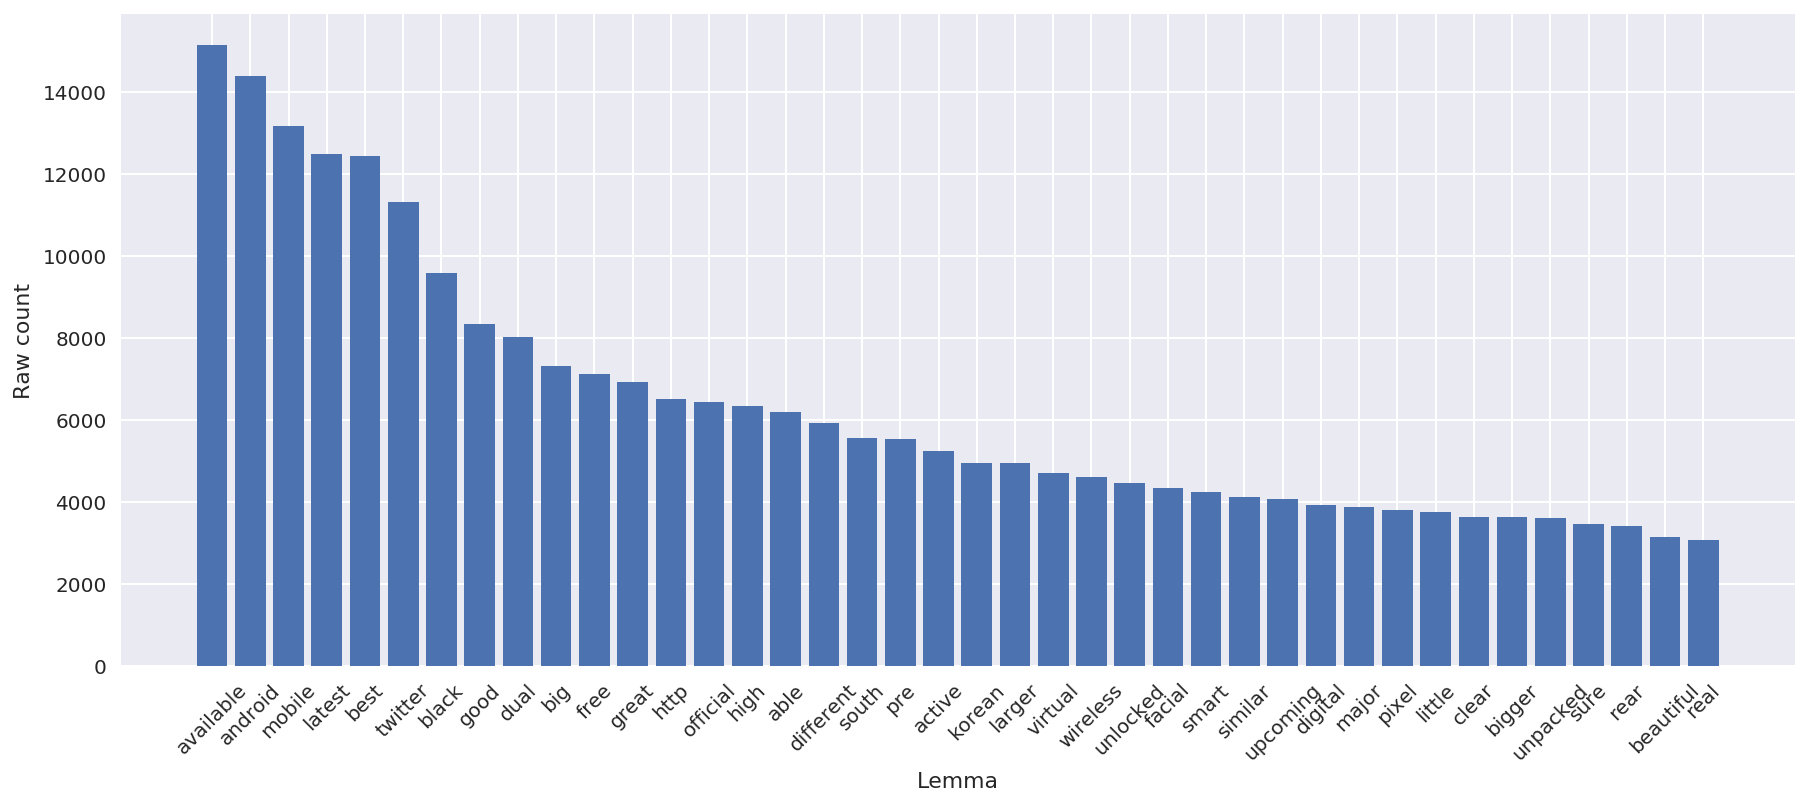

In [146]:
plt.figure(figsize = (15,6))
plt.style.use('seaborn')  
%config InlineBackend.figure_format = 'retina' 

num_top_lemmas_to_plot = 40
top_lemmas = [lemma for lemma, count in galaxy_sorted_lemma_count_pairs[:num_top_lemmas_to_plot]]
top_counts = [count for lemma, count in galaxy_sorted_lemma_count_pairs[:num_top_lemmas_to_plot]]
plt.bar(range(num_top_lemmas_to_plot), top_counts)
plt.xticks(range(num_top_lemmas_to_plot), top_lemmas, rotation=45)
plt.xlabel('Lemma')
plt.ylabel('Raw count')